In [1]:
import pandas as pd
import textwrap
from collections import defaultdict, Counter
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
# read data
df = pd.read_csv("../data/logs/hitlog_2025-10-27.csv")
df.head()

,page_name,page_url,user_id,timestamp
0,Tech | Scientists map deep-sea coral reefs,/articles/scientists-map-deep-sea-coral-reefs,u001,2025-10-26 16:02:57
1,Tech | Scientists map deep-sea coral reefs,/articles/scientists-map-deep-sea-coral-reefs,u001,2025-10-26 16:03:55
2,Science | Protein-rich lunches you can make fast,/articles/protein-rich-lunches-you-can-make-fast,u001,2025-10-26 16:06:26
3,World | Winners and losers from the tax changes,/articles/winners-and-losers-from-the-tax-changes,u001,2025-10-26 16:09:47
4,Lifestyle | Mortgage rates fall for third month,/articles/mortgage-rates-fall-for-third-month,u001,2025-10-26 16:11:04


In [3]:
print(df.shape)

(209, 4)


In [4]:
# Basic normalization / safety: strip whitespace, coerce timestamp
for col in ["page_name", "page_url", "user_id"]:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip()
if "timestamp" in df.columns:
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")

# Drop rows without a user_id or timestamp (cannot order)
df = df.dropna(subset=["user_id", "timestamp"]).copy()

# Visual Representation of unique Cases

In [5]:
REG_URL = "/register"


# Utility functions
def is_register(url: str) -> bool:
    return isinstance(url, str) and url.strip().startswith(REG_URL)


ARTICLE_PREFIX = "/articles/"


def is_article(url: str) -> bool:
    return isinstance(url, str) and url.strip().startswith(ARTICLE_PREFIX)

In [6]:
def label_page(row) -> str:
    """Create a concise label for a node in the journey graph."""
    if is_register(row["page_url"]):
        return "registration"
    if is_article(row["page_url"]):
        # prefer page_name if sensible, else last path component
        name = row.get("page_name", "")
        if isinstance(name, str) and name and name.lower() != "nan":
            label = name
        else:
            slug = row["page_url"].rstrip("/").split("/")[-1]
            label = slug or row["page_url"]
        return textwrap.shorten(label, width=40, placeholder="…")
    # non-article page
    if (
        isinstance(row["page_name"], str)
        and row["page_name"]
        and row["page_name"].lower() != "nan"
    ):
        return textwrap.shorten(row["page_name"], width=40, placeholder="…")
    return row["page_url"]

In [7]:
# Build ordered user journeys
df_sorted = df.sort_values(["user_id", "timestamp"]).copy()

user_paths = {}
for uid, g in df_sorted.groupby("user_id", sort=False):
    steps = g[["page_name", "page_url", "timestamp"]].to_dict("records")
    user_paths[uid] = steps

In [8]:
# Derive signatures and case classification
def journey_signature(steps):
    """Return signature up to first registration (exclusive), as tuple of page_url."""
    sig = []
    for s in steps:
        if is_register(s["page_url"]):
            break
        sig.append(s["page_url"])
    return tuple(sig)


def has_cycle(sig):
    """Detect if a signature has repeated pages (cycle) before registration."""
    seen = set()
    for url in sig:
        if url in seen:
            return True
        seen.add(url)
    return False


def has_non_article(sig):
    return any((not is_article(u)) and (not u.startswith(REG_URL)) for u in sig)


def registrations_in_steps(steps):
    return sum(1 for s in steps if is_register(s["page_url"]))


def case_type(steps):
    """Return a high-level case classification label."""
    reg_count = registrations_in_steps(steps)
    sig = journey_signature(steps)
    if reg_count == 0:
        return "NO_REG"  # no registration observed
    if reg_count > 1:
        return "MULTI_REG"  # exception: multiple registrations
    if len(sig) == 0:
        return "DIRECT_REG"  # landed on /register without prior page
    cyc = has_cycle(sig)
    non_art = has_non_article(sig)
    if cyc and not non_art:
        return "CYCLE_ARTICLES_BEFORE_REG"  # matches user's #2
    if not cyc and all(is_article(u) for u in sig):
        return "ARTICLES_THEN_REG"  # matches user's #1
    # mixed pages or cycles with non-article pages
    if cyc and non_art:
        return "CYCLE_MIXED_BEFORE_REG"
    if non_art:
        return "MIXED_PAGES_THEN_REG"
    return "OTHER"  # fallback


# Compute per-user annotations
records = []
sig_to_users = defaultdict(list)
sig_to_count = Counter()
case_to_users = defaultdict(list)

for uid, steps in user_paths.items():
    sig = journey_signature(steps)
    ctype = case_type(steps)
    cyc = has_cycle(sig)
    non_art = has_non_article(sig)
    reg_count = registrations_in_steps(steps)
    records.append(
        {
            "user_id": uid,
            "signature_len": len(sig),
            "signature": sig,
            "case_type": ctype,
            "has_cycle": cyc,
            "has_non_article": non_art,
            "registrations": reg_count,
        }
    )
    sig_to_users[sig].append(uid)
    sig_to_count[sig] += 1
    case_to_users[ctype].append(uid)

summary_df = pd.DataFrame.from_records(records)

In [9]:
# Unique cases = unique signatures (up to first registration)
unique_cases = (
    summary_df[["signature", "case_type"]]
    .drop_duplicates()
    .assign(users=lambda d: d["signature"].map(lambda s: sig_to_users[s]))
    .assign(count=lambda d: d["signature"].map(lambda s: sig_to_count[s]))
    .sort_values(["case_type", "count"], ascending=[True, False])
)

from IPython.display import display, HTML

display(HTML("<h3>Per-user journey summary (first registration focus)</h3>"))
display(summary_df)

display(HTML("<h3>Unique journey signatures and counts</h3>"))
display(unique_cases)

,user_id,signature_len,signature,case_type,has_cycle,has_non_article,registrations
0,u001,10,(/articles/scientists-map-deep-sea-coral-reefs...,CYCLE_ARTICLES_BEFORE_REG,True,False,1
1,u002,9,(/articles/volcano-eruption-prompts-evacuation...,CYCLE_ARTICLES_BEFORE_REG,True,False,1
2,u003,12,(/articles/mortgage-rates-fall-for-third-month...,CYCLE_ARTICLES_BEFORE_REG,True,False,1
3,u004,6,"(/articles/how-to-negotiate-your-salary, /arti...",NO_REG,True,False,0
4,u005,6,(/articles/critics-hail-revival-of-classic-pla...,NO_REG,True,False,0
5,u006,10,(/articles/new-smartphone-chips-promise-longer...,NO_REG,True,False,0
6,u007,0,(),DIRECT_REG,False,False,1
7,u008,6,"(/articles/five-habits-linked-to-longer-life, ...",CYCLE_ARTICLES_BEFORE_REG,True,False,1
8,u009,10,(/articles/new-smartphone-chips-promise-longer...,CYCLE_ARTICLES_BEFORE_REG,True,False,1
9,u010,9,(/articles/start-up-founders-on-surviving-down...,NO_REG,True,False,0


,signature,case_type,users,count
13,"(/articles/volcano-eruption-prompts-evacuations,)",ARTICLES_THEN_REG,[u014],1
0,(/articles/scientists-map-deep-sea-coral-reefs...,CYCLE_ARTICLES_BEFORE_REG,[u001],1
1,(/articles/volcano-eruption-prompts-evacuation...,CYCLE_ARTICLES_BEFORE_REG,[u002],1
2,(/articles/mortgage-rates-fall-for-third-month...,CYCLE_ARTICLES_BEFORE_REG,[u003],1
7,"(/articles/five-habits-linked-to-longer-life, ...",CYCLE_ARTICLES_BEFORE_REG,[u008],1
8,(/articles/new-smartphone-chips-promise-longer...,CYCLE_ARTICLES_BEFORE_REG,[u009],1
10,(/articles/flu-season--what-doctors-want-you-t...,CYCLE_ARTICLES_BEFORE_REG,[u011],1
11,"(/articles/gardeners--tips-for-late-blooms, /a...",CYCLE_ARTICLES_BEFORE_REG,[u012],1
15,(/articles/winners-and-losers-from-the-tax-cha...,CYCLE_ARTICLES_BEFORE_REG,[u016],1
16,"(/articles/how-to-back-up-your-photos, /articl...",CYCLE_ARTICLES_BEFORE_REG,[u017],1


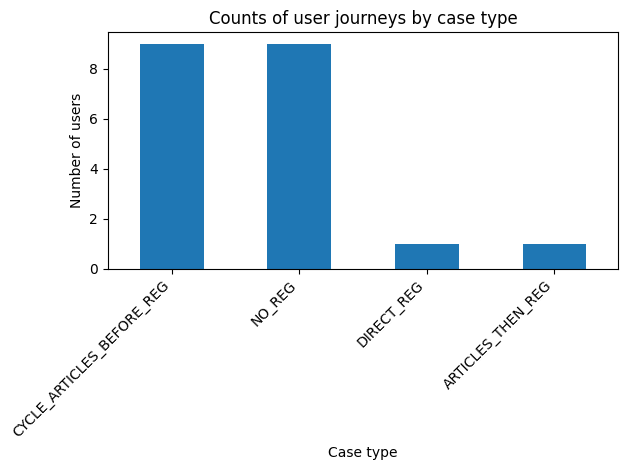

In [10]:
import matplotlib.pyplot as plt

# High-level bar chart of case counts
case_counts = summary_df["case_type"].value_counts().sort_values(ascending=False)

plt.figure()
case_counts.plot(kind="bar")
plt.title("Counts of user journeys by case type")
plt.xlabel("Case type")
plt.ylabel("Number of users")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [11]:
import networkx as nx


# Graph rendering helpers
def draw_journey_graph(steps, title="Journey graph"):
    """Draw a directed graph of the journey up to and including first registration."""
    # Collect nodes in order up to first /register (inclusive)
    nodes = []
    for s in steps:
        nodes.append(label_page(s))
        if is_register(s["page_url"]):
            break
    # If no registration, just draw up to end
    # Create edges between sequential nodes
    edges = list(zip(nodes[:-1], nodes[1:]))
    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    plt.figure()
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_size=1500, font_size=8, arrows=True)
    plt.title(title)
    plt.tight_layout()
    plt.show()

/var/folders/cr/zw_bcxpn257g4khbkhrtn_vm0000gn/T/ipykernel_90497/3773052038.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


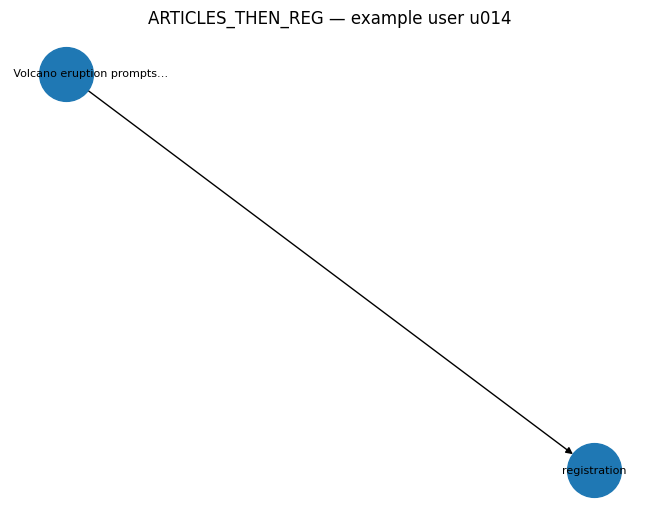

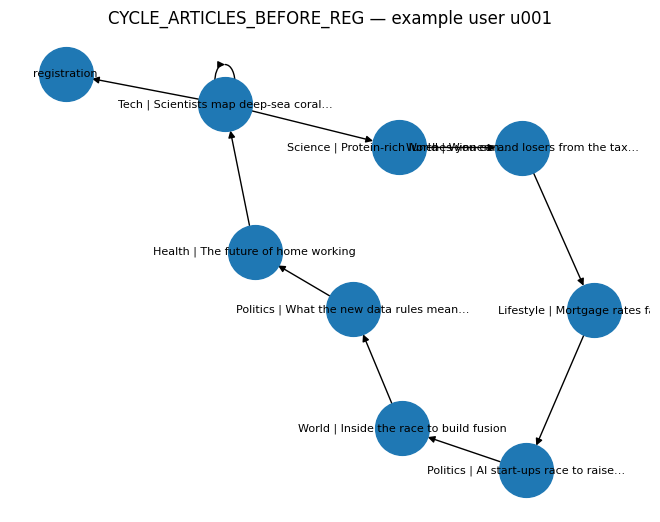

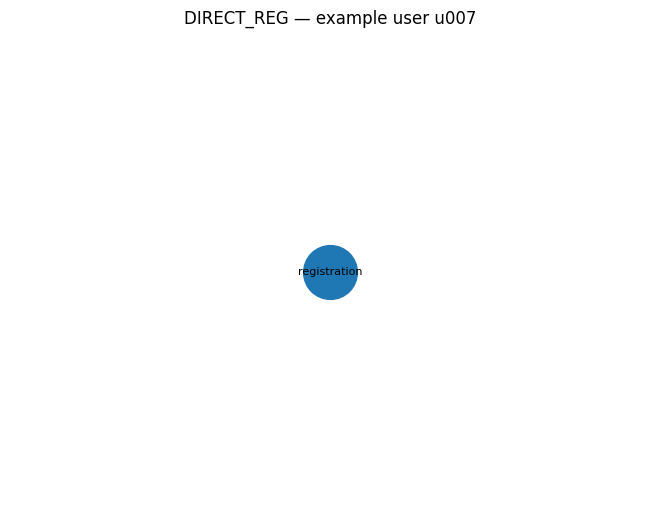

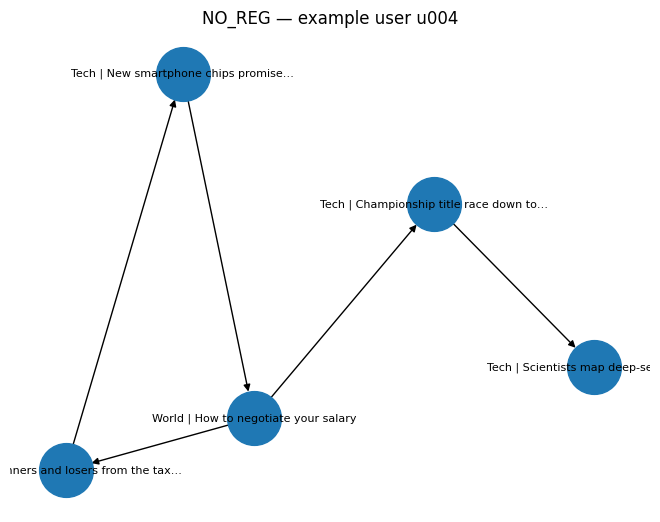

In [12]:
# Render example graphs per requested & relevant cases
requested_cases = [
    "ARTICLES_THEN_REG",
    "CYCLE_ARTICLES_BEFORE_REG",
]

other_cases = [
    "MIXED_PAGES_THEN_REG",
    "CYCLE_MIXED_BEFORE_REG",
    "DIRECT_REG",
    "MULTI_REG",
    "NO_REG",
    "OTHER",
]
MAX_EXAMPLES_PER_CASE = 1


def example_users_for_case(case_label, max_n=MAX_EXAMPLES_PER_CASE):
    users = case_to_users.get(case_label, [])
    return users[:max_n]


# Draw requested cases first
for c in requested_cases:
    users = example_users_for_case(c)
    for uid in users:
        steps = user_paths[uid]
        draw_journey_graph(steps, title=f"{c} — example user {uid}")

# Then draw a few examples for other informative cases
for c in other_cases:
    users = example_users_for_case(c, max_n=1)  # one example each to keep it concise
    for uid in users:
        steps = user_paths[uid]
        draw_journey_graph(steps, title=f"{c} — example user {uid}")

# Code - Data Engineering

In [13]:
import pandas as pd

In [14]:
# read data
df = pd.read_csv("../data/logs/hitlog_2025-10-27.csv")
df.head()

,page_name,page_url,user_id,timestamp
0,Tech | Scientists map deep-sea coral reefs,/articles/scientists-map-deep-sea-coral-reefs,u001,2025-10-26 16:02:57
1,Tech | Scientists map deep-sea coral reefs,/articles/scientists-map-deep-sea-coral-reefs,u001,2025-10-26 16:03:55
2,Science | Protein-rich lunches you can make fast,/articles/protein-rich-lunches-you-can-make-fast,u001,2025-10-26 16:06:26
3,World | Winners and losers from the tax changes,/articles/winners-and-losers-from-the-tax-changes,u001,2025-10-26 16:09:47
4,Lifestyle | Mortgage rates fall for third month,/articles/mortgage-rates-fall-for-third-month,u001,2025-10-26 16:11:04


In [15]:
REQUIRED_COLS = ["page_name", "page_url", "user_id", "timestamp"]


def _safe_read_csv(path: str) -> pd.DataFrame:
    """Read CSV robustly with proper dtypes and timestamp parsing; drop bad rows."""
    df = pd.read_csv(
        path,
        dtype={"page_name": "string", "page_url": "string", "user_id": "string"},
        keep_default_na=False,
    )
    # Normalize blanks to NaN and drop missing
    df = df.replace({"": pd.NA}).dropna(subset=["page_url", "user_id", "timestamp"])
    # Ensure required columns exist
    missing = [c for c in REQUIRED_COLS if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns in input: {missing}")
    # Parse timestamps
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce", utc=True)
    df = df.dropna(subset=["timestamp"])
    # Fill possible missing names as empty string (we'll resolve names later)
    if "page_name" in df.columns:
        df["page_name"] = df["page_name"].fillna("")
    return df

In [16]:
from typing import Tuple, Dict, Iterable


def _most_frequent_name_per_url(df: pd.DataFrame) -> Dict[str, str]:
    """Resolve a stable page_name per page_url using the most frequent observed name."""
    name_map: Dict[str, str] = {}
    for url, grp in df.groupby("page_url", dropna=False):
        if "page_name" in grp.columns:
            names = grp["page_name"].dropna().astype(str)
            if len(names) == 0:
                name_map[url] = ""
            else:
                top_name = names.value_counts().idxmax()
                name_map[url] = top_name
        else:
            name_map[url] = ""
    return name_map

In [17]:
REGISTRATION_URL = "/register"
ARTICLE_PREFIX = "/articles/"


def compute_influential_articles(df: pd.DataFrame) -> pd.DataFrame:
    """
    Core transformation:
    - Sort each user's events by timestamp
    - For each registration event, count each unique article (by page_url) that occurred
      since the previous registration for that user.
    - Aggregate counts across all users and return a DataFrame with columns
      [page_name, page_url, total] sorted by total desc (ties by page_url asc).
    """
    # Filter only article and registration hits to keep memory small
    df = df.loc[
        df["page_url"].str.startswith(ARTICLE_PREFIX)
        | (df["page_url"] == REGISTRATION_URL)
    ].copy()
    if df.empty:
        return pd.DataFrame(columns=["page_name", "page_url", "total"])

    # Resolve stable names up-front (based on all occurrences)
    url_to_name = _most_frequent_name_per_url(df)

    # Sort for deterministic traversal
    df = df.sort_values(["user_id", "timestamp"], kind="mergesort")

    # Accumulate counts
    counter: Counter = Counter()

    # Iterate per user
    for user_id, grp in df.groupby("user_id", sort=False):
        # Maintain set of unique articles seen since last registration
        since_last_reg: set[str] = set()
        for _, row in grp.iterrows():
            url = str(row["page_url"])
            if url == REGISTRATION_URL:
                # Registration event: increment all unique articles in the current journey
                for art in since_last_reg:
                    counter[art] += 1
                # Reset for the next journey
                since_last_reg.clear()
            elif url.startswith(ARTICLE_PREFIX):
                # Record article in current journey
                since_last_reg.add(url)

        # If the user has leftover articles without a trailing registration,
        # they do NOT count (no registration occurred yet).

    if not counter:
        return pd.DataFrame(columns=["page_name", "page_url", "total"])

    # Build result DataFrame
    data = []
    for url, total in counter.items():
        data.append(
            {
                "page_url": url,
                "page_name": url_to_name.get(url, ""),
                "total": int(total),
            }
        )
    out = pd.DataFrame(data, columns=["page_name", "page_url", "total"])
    # Sort by total desc, then page_url for stable order
    out = out.sort_values(
        ["total", "page_url"], ascending=[False, True], kind="mergesort"
    ).reset_index(drop=True)
    return out

In [18]:
INPUT_PATH = "../data/logs/hitlog_2025-10-27.csv"
OUTPUT_PATH = "../data/outputs/top_influential_articles_2025-10-27.csv"


def run_pipeline(
    input_path: str = INPUT_PATH, output_path: str = OUTPUT_PATH, top_n: int = 3
) -> Tuple[pd.DataFrame, str]:
    """Execute the full pipeline and persist the top N to CSV. Returns (full_df_sorted, output_path)."""
    df = _safe_read_csv(input_path)
    result_df = compute_influential_articles(df)
    top_df = result_df.head(top_n)
    # Persist
    top_df.to_csv(output_path, index=False)
    return top_df, output_path


# Execute on the provided CSV
top_df, out_path = run_pipeline(INPUT_PATH, OUTPUT_PATH, top_n=3)

# Display to user in a spreadsheet-style view
print("Top 3 Influential Telegraph Articles")
print(top_df.head(3))

print("Wrote output to:", out_path)

Top 3 Influential Telegraph Articles
                                         page_name  \
0  World | Winners and losers from the tax changes   
1  Tech | Championship title race down to the wire   
2             Science | How to back up your photos   

                                            page_url  total  
0  /articles/winners-and-losers-from-the-tax-changes      5  
1  /articles/championship-title-race-down-to-the-...      4  
2               /articles/how-to-back-up-your-photos      3  
Wrote output to: ../data/outputs/top_influential_articles_2025-10-27.csv
